In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_009265, selected_008229
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from target import build_tgt_matrix
from loading import load_session_data

np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
sessions = [s for s in selected_008229.keys()]
sessions.sort()
sessions

['008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-18_14-36-18',
 '008229_hippoSIT_2022-05-20_15-54-39']

In [5]:
session = sessions[2]
session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'008229_hippoSIT_2022-05-18_14-36-18'

## Construct event arrays

In [6]:
# reward timeline
idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)
reward_tl = np.zeros(len(tl))
for idx in idxs_reward:
    reward_tl[idx:idx+100] = 1  # 1 second for a reward

# target sound timeline
sound_tg = np.zeros(len(tl))
sound_tg[tl[:, 6] == 2] = 1

# backgound sound
sound_bg = np.zeros(len(tl))
sound_bg[tl[:, 6] == 1] = 1

# noise
sound_ns = np.zeros(len(tl))
sound_ns[tl[:, 6] == -1] = 1

# onset event indices
idxs_backgr = np.where(tl[:, 6] == 1)[0]
idxs_to_idx = np.where(np.diff(idxs_backgr) > 5)[0] + 1
idxs_bgr_start = idxs_backgr[:-1][idxs_to_idx[:-1]]

idxs_noise  = np.where(tl[:, 6] ==-1)[0]
idxs_to_idx = np.where(np.diff(idxs_noise) > 5)[0] + 1
idxs_nos_start = np.concatenate([[idxs_noise[0]], idxs_noise[:-1][idxs_to_idx]])

# min_dur = 0
# idxs_target = np.where(tl[:, 6] == 2)[0]
# idxs_to_idx1 = np.where(np.diff(idxs_target) > 5)[0] + 1 # target starts
# idxs_to_idx2 = np.where(np.diff(idxs_target) > 5)[0][1:] # target ends
# idxs_to_idx  = np.where(idxs_to_idx2 - idxs_to_idx1[:-1] > min_dur * 100)[0]
# idxs_tgt_start = idxs_target[:-1][idxs_to_idx1[idxs_to_idx]]
idxs_tgt_start = tgt_matrix[:, 0]

idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)

# binary onset events
reward_onset = np.zeros(len(tl))
reward_onset[idxs_reward] = 1  # reward_onset[idx:idx+50] = 1

backgr_onset = np.zeros(len(tl))
backgr_onset[idxs_bgr_start] = 1

target_onset = np.zeros(len(tl))
target_onset[idxs_tgt_start] = 1

noise_onset = np.zeros(len(tl))
noise_onset[idxs_nos_start] = 1    

In [7]:
spu = {
    '008229_hippoSIT_2022-05-17_21-44-43': '1-19',  # FIXME dummy pellet unit 
    '008229_hippoSIT_2022-05-16_20-36-44': '3-3',
    '008229_hippoSIT_2022-05-20_15-54-39': '6-7',
    '008229_hippoSIT_2022-05-18_14-36-18': '1-16'
}

# pellet chewing
with h5py.File(h5_file, 'r') as f:
    pellet_s_times = np.array(f['units'][spu[session]][H5NAMES.spike_times['name']])
    #pellet_i_rate = np.array(f['units'][pellet_unit][H5NAMES.inst_rate['name']])
    pellet_i_rate = instantaneous_rate(pellet_s_times, tl[:, 0], k_width=200)  # make it more crispy if needed

idxs_pellet = np.where(pellet_i_rate > 0.4)[0]  # 0.4 Hz criteria for chewing
idxs_to_idx = np.where(np.diff(idxs_pellet) > 5)[0] + 1
idxs_pel_start = np.concatenate([[idxs_pellet[0]], idxs_pellet[:-1][idxs_to_idx]])

s_rate = 100  # Hz
pellet_ev = np.zeros(len(tl))
for idx in idxs_pel_start:
    pellet_ev[idx:idx + 3*s_rate] = 1

## Speed

In [8]:
speed_bgr_only = tl[tl[:, 6] == 1][:, 3]

unit_speed_corrs = {}
for unit_name, inst_rate in single_units.items():
    unit_speed_corrs[unit_name] = pearsonr(speed_bgr_only, inst_rate[tl[:, 6] == 1])[0]

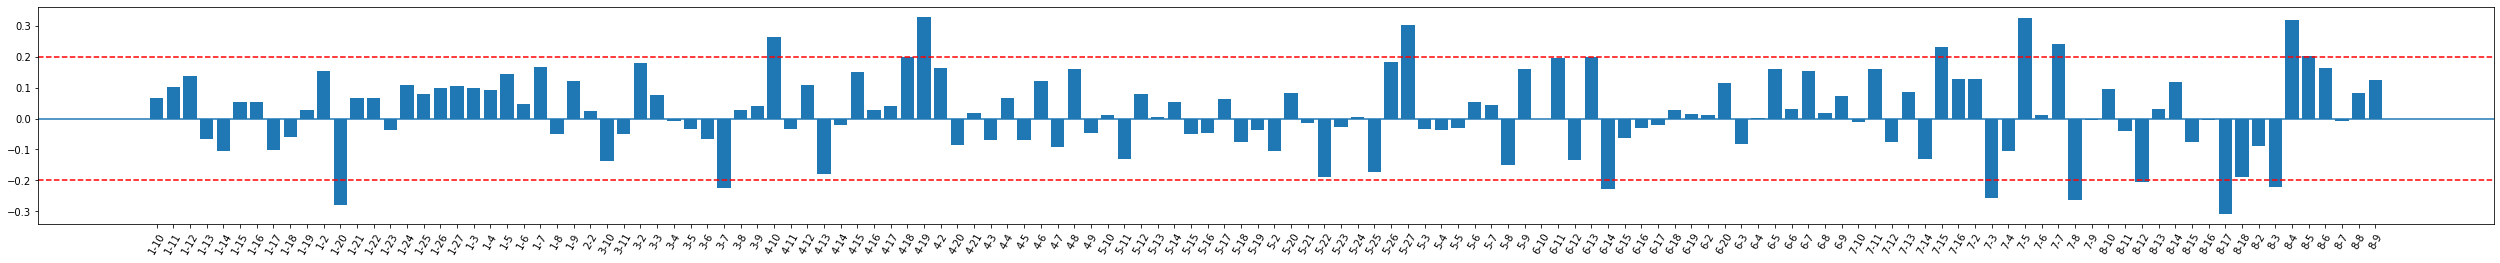

In [9]:
unit_count = len(unit_speed_corrs)

fig, ax = plt.subplots(1, 1, figsize=(int(unit_count/3), 4))
ax.bar(range(unit_count), unit_speed_corrs.values())
ax.set_xticks(range(unit_count))
ax.set_xticklabels(unit_speed_corrs.keys(), rotation=60)
ax.axhline(0.2, ls='--', color='r')
ax.axhline(-0.2, ls='--', color='r')
ax.axhline(0)
fig.savefig(os.path.join(report_path, 'unit_speed_corr.pdf'))

In [10]:
[(k, v) for k, v in unit_speed_corrs.items() if np.abs(v) > 0.2]

[('1-20', -0.27934844512601026),
 ('3-7', -0.22436231133762477),
 ('4-10', 0.2626264502615201),
 ('4-18', 0.2004895272095097),
 ('4-19', 0.330274788527119),
 ('5-27', 0.3039984602812368),
 ('6-14', -0.2293396330818138),
 ('7-15', 0.23059781521165007),
 ('7-3', -0.2567313957505727),
 ('7-5', 0.3262782325431412),
 ('7-7', 0.23987125825067718),
 ('7-8', -0.2628734861420174),
 ('8-12', -0.20417888412764135),
 ('8-17', -0.3098241301852662),
 ('8-3', -0.220330013936649),
 ('8-4', 0.31873962327314903),
 ('8-5', 0.20373674040775605)]

## Cross-event

In [11]:
# units
to_plot = dict(list(single_units.items())[:])

# ALSO TRY AEP metrics
# P2 is high when entering island - in 009266_hippoSIT_2023-05-25_15-55-57

# also try coupling between metrics

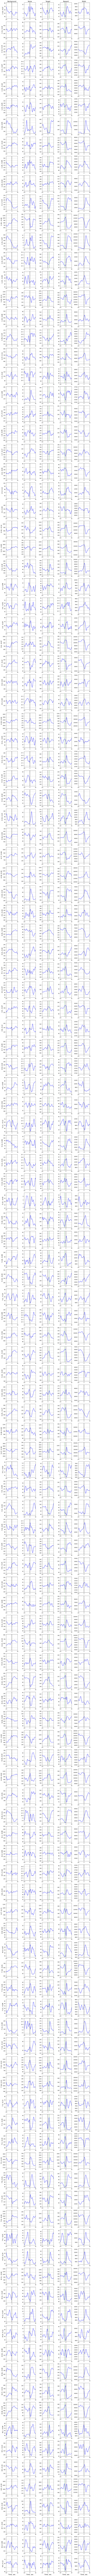

In [12]:
fig = plt.figure(figsize=(12, 2.5*len(to_plot)))

t_lag  = 20  # seconds
j = 0
s_rate = 100

titles = ['Background', 'Noise', 'Target', 'Reward', 'Pellet']
for ass_id, i_rate in to_plot.items():
    for i, var_all in enumerate([
            (sound_bg, backgr_onset), 
            (sound_ns, noise_onset), 
            (sound_tg, target_onset), 
            (reward_tl, reward_onset),
            (reward_tl, pellet_ev),
        ]):
        ax = fig.add_subplot(len(to_plot), 5, i+1 + 5*j)

        for k, var_tl in enumerate(var_all[1:2]):
            corr = signal.correlate(i_rate, var_tl)
            lags = signal.correlation_lags(len(var_tl), len(i_rate))

            idx_l, idx_r = int(len(lags)/2) - t_lag*s_rate, int(len(lags)/2) + t_lag*s_rate
            y_min = 0.8*corr[idx_l:idx_r].min()
            y_max = 1.2*corr[idx_l:idx_r].max()

            ax.plot(lags[idx_l:idx_r]/100, corr[idx_l:idx_r], color='blue' if k==0 else 'orange')

        if i == 0:
            ax.set_ylabel("%s, %.2f" % (ass_id, unit_speed_corrs[ass_id]), fontsize=14)
        if i == 2:
            ax.axvline(5, color='green', ls='--')
        if i == 3:
            ax.axvline(-5, color='green', ls='--')

        ax.axvline(0, color='black')
        ax.set_xlim(-t_lag, t_lag)
        ax.set_ylim(y_min, y_max)
        if j == 0:
            ax.set_title(titles[i], fontsize=14)
        if j == len(to_plot) - 1:
            ax.set_xlabel('Time, sec', fontsize=14)
        ax.grid()
    j += 1
    
fig.tight_layout()
fig.savefig(os.path.join(report_path, 'CCR_events.pdf'))